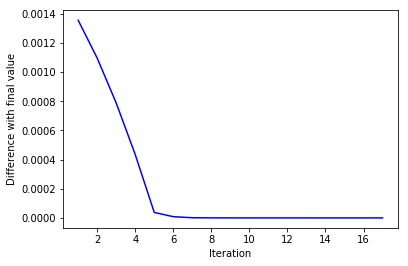

Calculated:
Function:  16
Gradient:  16
Gessian:  16
Point:  [1.28337796e-01 2.80007338e-02 2.51779661e-09 4.68696877e-02
 1.55398844e-01 5.67310481e-02 1.01839590e-01 1.66554743e-01
 2.40742672e-01 6.46734836e-02]
Value:  1.8742123258823227


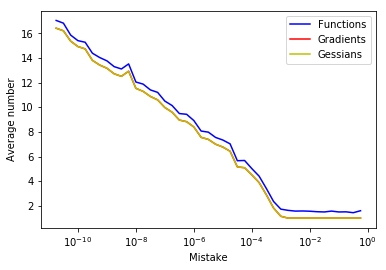

In [2]:
import numpy as np
import scipy.stats as st
import copy
import math
import matplotlib
from matplotlib import pyplot as plt

class Oracle:
    def __init__(self, p, pi):
        assert(p.shape[1] == pi.shape[0])
        self.__pi = copy.copy(pi)
        self.__p = copy.copy(p)
        self.__calc = 0
        self.__grad = 0
        self.__gess = 0
    
    def Calculate(self, x):
        self.__calc += 1
        return np.sum(self.__pi * np.log(self.__p.T @ x))
    
    def CalculateGradient(self, x):
        self.__grad += 1
        return self.__p @ (self.__pi * (self.__p.T @ x)**(-1))
    
    def CalculateGessian(self, x):
        self.__gess += 1
        return -1.0 * self.__p @ np.diagflat(self.__pi * (self.__p.T @ x)**(-2)) @ self.__p.T
    
    @property
    def Calculated(self):
        return self.__calc;
    
    @property
    def CalculatedGradients(self):
        return self.__grad;
    
    @property
    def CalculatedGessians(self):
        return self.__gess;
    
def Normalization(A):
    assert(A.shape[0] == A.shape[1])
    return A - np.eye(A.shape[0])
    
class NewtonIterator:
    def __init__(self, begin, oracle, projector, step_choser, priority, checker, normalizator):
        self.__point = copy.copy(begin)
        self.__oracle = copy.copy(oracle)
        self.__projector = copy.copy(projector)
        self.__step_choser = copy.copy(step_choser)
        self.__priority = copy.copy(priority)
        self.__checker = copy.copy(checker)
        self.__normalizator = copy.copy(normalizator)
        self.__step = 1.0
        self.__value = oracle.Calculate(begin)
    def MakeStep(self):
        gess = self.__oracle.CalculateGessian(self.__point)
        grad = self.__oracle.CalculateGradient(self.__point)
        gess = np.linalg.inv(self.__normalizator(gess))
        direction = gess @ self.__projector(grad)
        old_value = self.__value
        improve = False
        while (not improve):
            new_point = self.__point - self.__step * direction
            if (not self.__checker(new_point)):
                self.__step = self.__step_choser(self.__step, False)
            else:
                new_value = self.__oracle.Calculate(new_point)
                improve = self.__priority(new_value, old_value)
                self.__step = self.__step_choser(self.__step, improve)
                if (improve):
                    self.__point = new_point
                    self.__value = new_value
    
    @property
    def Oracle(self):
        return self.__oracle
    
    @property
    def Value(self):
        return self.__value
    
    @property
    def Point(self):
        return self.__point
    
def Projector(x):
    y = x - (np.ones(x.size) @ x) * np.ones(x.size) / x.size
    return y

def StepChoser(prev, success):
    next = prev
    if success:
        if (next < 1.0):
            next *= 2.0
            if (next > 1):
                next = 1.0
    else:
        next /= 2.0
    return next 

def Checker(x):
    if (not np.all(x > 0)):
        return False
    else:
        return True
    
class NewtonSpecializator(NewtonIterator):
    def __init__(self, begin, p, pi):
        priority = lambda x, y: x >= y
        NewtonIterator.__init__(self, begin, Oracle(p, pi), Projector, StepChoser, priority, Checker, Normalization)
        
def FindMax(begin, p, pi, mistake):
    iterator = NewtonSpecializator(begin, p, pi)
    prev = iterator.Value
    finished = False
    while(not finished):
        iterator.MakeStep()
        next = iterator.Value
        finished = (np.abs(next - prev) < mistake)
        prev = next
    return iterator

def GraphicMax(begin, p, pi, mistake):
    iterator = NewtonSpecializator(begin, p, pi)
    iterations = np.array([iterator.Value])
    prev = iterator.Value
    finished = False
    while(not finished):
        iterator.MakeStep()
        iterations = np.append(iterations, iterator.Value)
        next = iterator.Value
        finished = (np.abs(next - prev) < mistake)
        prev = next
    plt.xlabel("Iteration")
    plt.ylabel("Difference with final value")
    plt.plot(np.arange(iterations.size) + 1, prev - iterations, "b-")
    plt.show()
    return iterator

def IterationsMistake(n, m, mistake):
    N = 100
    iterations_calc = np.zeros(0)
    iterations_grad = np.zeros(0)
    iterations_gess = np.zeros(0)
    for diff in mistake:
        calc = 0
        grad = 0
        gess = 0
        for i in range(N):
            p = np.abs(np.random.rand(n, m) * 5 + 0.5)
            pi = np.abs(np.random.rand(m))
            pi /= np.sum(pi)
            begin = np.ones(n) / n
            iterator = FindMax(begin, p, pi, diff)
            calc += iterator.Oracle.Calculated
            grad += iterator.Oracle.CalculatedGradients
            gess += iterator.Oracle.CalculatedGessians
        calc /= N
        grad /= N
        gess /= N
        iterations_calc = np.append(iterations_calc, calc)
        iterations_grad = np.append(iterations_grad, grad)
        iterations_gess = np.append(iterations_gess, gess)
    plt.xlabel("Mistake")
    plt.ylabel("Average number")
    plt.semilogx(mistake, iterations_calc, "b-")
    plt.semilogx(mistake, iterations_grad, "r-")
    plt.semilogx(mistake, iterations_gess, "y-")
    plt.legend(["Functions", "Gradients", "Gessians"])
    plt.show()


n = 10
m = 100

p = np.abs(np.random.rand(n, m) * 3 + 5)
pi = np.abs(np.random.rand(m))
pi /= np.sum(pi)

begin = np.ones(n) / n

iterator = GraphicMax(begin, p, pi, 10**(-10))

print("Calculated:")
print("Function: ", iterator.Oracle.Calculated)
print("Gradient: ", iterator.Oracle.CalculatedGradients)
print("Gessian: ", iterator.Oracle.CalculatedGessians)
print("Point: ", iterator.Point)
print("Value: ", iterator.Value)
IterationsMistake(n, m, 10**(-1 * np.arange(1, 44) / 4.0))

In [11]:
x = np.array([2.0, 0.0])

np.all(x > 1)

False